<a href="https://colab.research.google.com/github/Muhammadsulton1/MIPT_Data_analys/blob/main/Lesson7_A_B_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 7 (неделя 8): A/B-тестирование
=====

In [ ]:
# Импорт библиотек для работы со статистикой
import numpy as np
import pandas as pd
import scipy.stats as sts
import statsmodels as stm


# Импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Стиль для графиков
plt.style.use('ggplot')
%matplotlib inline

## 1. A/B тест в мобильной игре (Коты и печеньки)

Посмотрим на данные одной мобильной игры под названием "Cookie Cats", разработанной компанией Tactile Entertainment. Это стандартный match-three пазл, где игрокам нужно соединять элементы одинаковых цветов, чтобы очистить поле и выиграть на уровне.

По мере того, как игроки проходят уровни, они встречают ворота-блокеры, которые вынуждают их либо ждать длительное время, либо совершить внутриигровую покупку, чтобы продолжить играть. Помимо того, что эти ворота приносят разработчикам деньги от покупок, они еще и вынуждают игроков делать перерыв, в надежде на то, что те вернутся с новыми силами и снова начнут получать удовольствие от котиков.

Но возникает вопрос - когда и где ставить эти ворота? Изначально первые ворота стояли на 30-м уровне игры, однако в этом ноутбуке мы будем анализировать АБ-тест, в котором разработчики передвинули ворота на 40-й уровень. В частности мы будем смотреть влияние этого изменения на такой важный показатель как "retention" или удержание игроков, который расчитывается как отношение уникальных игроков, зашедших в игру на 1-й, 2-й, ... N-й день после установки ко всем игрокам, установившим приложение в этот день.

In [ ]:
df = pd.read_csv('cookie_cats.csv', sep=";")
print(df.shape)
df.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Описание колонок:

__userid__ - уникальный номер, идентифицирующий каждого игрока.
__version__ - был ли пользователь отнесен к контрольной группе (gate_30 - ворота на 30-м уровне) или к тестовой (gate_40 - ворота на 40-м уровне).
__sum_gamerounds__ - число сессий, сыгранных игроком в течение первых 14 дней после установки игры.
__retention_1__ - вернулся ли игрок после первого дня с момента установки?
__retention_7__ - вернулся ли игрок после седьмого дня с момента установки?

Когда игрок устанавливает игру, он/она случайным образом относятся либо к группе gate_30, либо gate_40. На всякий случай, давайте проверим, действительно ли их примерно поровну в каждой из группу.

In [ ]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

Похоже, что игроков действительно примерно поровну в каждой из групп, отлично!

Фокус нашего анализа будет сосредоточен на удержании игроков (retention), но ради интереса давайте построим распределение числа игровых сессий, сыгранных игроками в течение их первой недели жизни в игре.

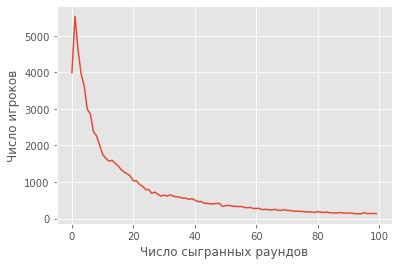

In [ ]:
# Считаем число игроков, оставшееся в игре для каждого раунда
plot_df = df.groupby('sum_gamerounds')['userid'].count()

ax = plot_df.head(100).plot()
ax.set_xlabel("Число сыгранных раундов")
ax.set_ylabel("Число игроков");

На графике вверху мы видим, что некоторые игроки установили игру, но даже ни разу не поиграли (0 сессий), многие игроки закончили лишь пару сессий за первую неделю, а некоторые действительно подсели и сыграли более 80 раз!

Конечно, мы хотим, чтобы игроки были заинтересованы в игре и возвращались в неё снова и снова. Обычная метрика, использующаяся в игровой индустрии, чтобы измерить, насколько игра веселая и захватывающая, - это удержание первого дня (1-day retention): Процент игроков, которые вренулись и снова стали играть спустя 1 день после установки. Чем выше удержание первого дня, тем проще и дальше удерживать пользователей и строить себе большую базу фанатов.

## Удержание первого дня (1-day retention)

Посмотрим как выглядит удержание 1 дня:

In [ ]:
df.retention_1.mean()

0.4452095044850259

А теперь по группам.

In [ ]:
df.groupby('version').retention_1.mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Похоже, что у нас есть небольшое ухудшение в удержании первого дня, если мы двигаем ворота к сороковому уровню (44.2%) в сравнении с контрольной группой, где ворота остались на 30-м уровне (44.8%). Разница, конечно, невелика, но даже маленькие изменения в удержании могут иметь значительные последствия. Давайте проверим значимость этого эффекта. Будем использовать тест о равенстве долей:

$$
H_0: p_{40} = p_{30} \\
H_1: p_{40} < p_{30}
$$

> __Предпосылки:__ нет выбросов, много наблюдений. Наблюдения независимы. Тогда сможем использовать ЦПТ.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05    # уровень значимости = 5%

df_agg = df.groupby('version').retention_1.agg(['sum', 'count', 'mean'])
df_agg

,sum,count,mean
version,,,
gate_30,20034,44700,0.448188
gate_40,20119,45489,0.442283


In [ ]:
n_obs = df_agg['count'].values  # размеры выборок
n_obs

array([44700, 45489])

In [ ]:
m_obs = df_agg['sum'].values    # число успехов
p_obs = df_agg['mean'].values   # доли

z_obs, p_val =  proportions_ztest(m_obs,
                                  n_obs,
                                  value=0,
                                  alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение статистики: 1.78
P-значение: 0.0372


Гипотеза о равенсве долей отвергается на $5\%$ уровне значимости. Посмотрим на оценку мощности этого эксперимента.

In [ ]:
n_30, n_40 = n_obs  # размеры выборок
p_30, p_40 = p_obs  # доли

# дисперсии
var_40, var_30 = p_40 * (1 - p_40), p_30 * (1 - p_30)

# стандартизированный размер эффекта
effect = (p_30 - p_40) / ((n_40* np.sqrt(var_40) + n_30 * np.sqrt(var_30)) / (n_40 + n_30))
effect

0.01188210610259806

In [ ]:
n_obs[1]/n_obs[0]

1.0176510067114093

In [ ]:
from statsmodels.stats.power import zt_ind_solve_power

zt_ind_solve_power(effect_size=effect,
                   nobs1=sum(n_obs),
                   alpha=0.05,
                   power=None,
                   ratio=n_obs[1]/n_obs[0],
                   alternative='larger')

0.8131005106557109

## Удержание седьмого дня (1-day retention)

Cпустя неделю после установки, уже больше игроков пройдут 40 уровней, поэтому имеет смысл посмотреть на удержание седьмого дня. Т.е., какой процент людей, установивших игру, снова показался в игре через 7 дней.

In [ ]:
df.groupby('version').retention_7.mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Как и с 1-day retention, мы видим, что 7-day retention немного ниже (18.2%), когда ворота находятся на 40-м уровне, чем на 30-м (19.0%). Эта разница также выше, чем для удержания первого дня, скорее всего из-за того, что игроки имели больше времени на то, чтобы столкнуться с первыми воротами. Мы также видим, что удержание 7-го дня в целом ниже, чем удержание 1-го - спустя неделю намного меньше людей всё ещё заходит в игру. По-прежнему возникает вопрос: а значима ли эта разница?

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                    # уровень значимости = 5%

df_agg = df.groupby('version').retention_7.agg(['sum', 'count', 'mean'])

n_obs = df_agg['count'].values  # размеры выборок
m_obs = df_agg['sum'].values    # число успехов
p_obs = df_agg['mean'].values   # доли

z_obs, p_val =  proportions_ztest(m_obs, n_obs, value=0, alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение статистики: 3.16
P-значение: 0.000777


Видим, что разница сильно значима. Для 7-дневного удержания произойдёт довольно мощный обвал.

## Выводы

Итак, результаты АБ-теста говорят нам о том, что есть значительное доказательство превышения 7-day retention в группе с воротами на 30-м уровне над группой с воротами на 40-м. Значит, если мы хотим поддерживать удержание клиентов на высоком уровне и иметь большее число игроков, нам не нужно сдвигать ворота с 30-го на 40-й уровень.

Так почему же удержание выше, когда ворота расположены раньше? Логично было бы ожидать обратной ситуации - чем позже ставится препятствие, тем дольше игроки будут взаимодействовать с игрой. Однако это не то, что мы видим в данных. Теория гедонистической адаптации может помочь с объяснением. Если вкратце, гедонистическая адаптация - это тенденция получать всё меньше и меньше удовольствия от деятельности, если она продолжается длительное время. Заставляя игроков сделать паузу, когда они достигают 30-го уровня, мы продлеваем им удовольствие от игры, в результате чего они хотят в неё возвращаться. И напротив, сдвигая ворота к 40-му уровню мы даем игрокам возможность наиграться и просто заскучать.

> __Вопрос:__ что мы сделали неправильно?

> __Ответ:__ при проведении эксперимента и проверке гипотезы мы никак не учитываем, что часть игроков вообще могла не дойти до ворот. Такие люди не остались в игре по каким-то иным причинам, не связанным с воротами. Если бы у нас были данные, связанные с этим, нам нужно было бы отфильтровать пользователей, которые не дошли в первый день до 30-го уровня.

---
---

## 2. Необходимое количество наблюдений

У нас есть две кнопки: старая и новая. Мы хотим проверить гипотезу о том, что доля нажатий по обеим кнопкам совпадает. В качестве альтернативы рассматриваем вариант, что новый дизайн кнопки оказался лучше и нажать на неё хочется больше.

Величины $p_0$ и $p_a$ мы оцениваем, как отношение кликов на кнопку к показам в контрольной группе и в тестовой группе. Число наблюдений, которое нам необходимо, в таком случае, можно найти по формуле:



$$
\beta = \mathbb{P}( H_0 | H_a) \\
\\
\beta = \mathbb{P} \left ( \frac{\hat p - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}} \leq Z_{1-\alpha} | p = p_a \right) \\
\\
se_0 = \sqrt{\frac{p_0(1-p_0)}{n}}, se_a = \sqrt{\frac{p_a(1-p_a)}{n}}\\
 \\
\frac{\hat p - p_a}{se_a} \leq \frac{se_0}{se_a}Z_{1-\alpha} + \frac{p_0 - p_a}{se_a} \\
  \\
\beta = \Phi \left (   \frac{se_0}{se_a}Z_{1-\alpha} + \frac{p_0 - p_a}{se_a}  \right) \\
Z_{\beta} = - Z_{1-\beta} = \frac{se_0}{se_a}Z_{1-\alpha} + \frac{p_0 - p_a}{se_a} \\
\\
\sqrt{n}(p_a - p_0) = \left ( \sqrt{p_a(1-p_a)}Z_{1-\beta} + \sqrt{p_0(1-p_0)}Z_{1-\alpha} \right)\\
\\
n = \left (  \frac{\sqrt{p_a(1-p_a)}Z_{1-\beta} + \sqrt{p_0(1-p_0)}Z_{1-\alpha}}{p_a - p_0} \right)^2
$$

где $n$- число наблюдений, $\alpha$ - ошибка первого рода, $\beta$ - ошибка второго рода, $z_{1 - \alpha}, z_{1 - \beta}$ - квантили нормального распределения.

In [ ]:
def get_size(p0, pa, alpha, beta):
    za = sts.norm.ppf(1 - alpha)
    zb = sts.norm.ppf(1 - beta)
    n = za * np.sqrt(p0*(1 - p0)) + zb * np.sqrt(pa*(1-pa))
    n /= (pa - p0)
    return int(np.ceil(n*n))

alpha = 0.05
beta = 0.05

# сколько наблюдений надо, чтобы получить ошибки alpha и beta
# и уловить минимальный эффект pa - p0
get_size(0.1, 0.15, alpha, beta)

468

Теперь посчитаем тоже самое с помощью пакета statsmodels. Внутри него есть функция zt_ind_solve_power. Она может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной пишется None.

Обратите внимание, что в качестве размера эффекта в функцию подаётся стандартизированный эффект, а не оригинальный (отнормированный на стандартное отклонение)

$$
effect = \frac{p_0 - p_a}{se},
$$
при этом стандартная ошибка считается как

$$
se = \sqrt{\frac{(n_0 - 1)\cdot s_0^2 + (n_a - 1) \cdot s_a^2 }{n_0 + n_a - 2}}.
$$

> Вспоминаем, как выглядит оценка дисперсии в t-статистике:

$$
t = \frac{\bar x - \bar y}{ \sqrt{\frac{s^2}{n_x} + \frac{s^2}{n_y}} } \sim t_{crit}(n+m-2)
$$

$$
s^2 = \frac{(n-1)s_x^2 + (m-1)s_y^2}{(n-1)+(m-1)}
$$

In [ ]:
n_0, n_a = 468, 468   # размеры выборок
p_0, p_a = 0.1, 0.15  # доли

# дисперсии
var_0, var_a = p_0 * (1 - p_0),  p_a * (1 - p_a)

# стандартизированный размер эффекта
(p_a - p_0) / np.sqrt((n_0 * var_0 + n_a * var_a) / (n_0 + n_a))

0.15161960871578062

In [ ]:

from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

# параметр ratio отвечает за то в какой из двух выборок больше наблюдений
sample_size = zt_ind_solve_power(
                    effect_size=0.15162,  # стандартизованный размер эффекта
                    nobs1=None,           # число наблюдений None, тк их хотим найти
                    alpha=alpha,          # уровень значимости
                    power=(1 - beta),     # мощность
                    ratio=1,              # перекос в выборках; если 0, тогда выборка только одна
                    alternative='larger'  # альтернатива
                )

print(sample_size/2) # у нас две выборки, на каждую поровну

470.76213074225996


Подставив None вместо другого аргумента функции, можем рассчитать что-нибудь ещё. Например, мощность теста.

In [ ]:
zt_ind_solve_power(effect_size=0.15162,
                   nobs1=100,
                   alpha=alpha,
                   power=None,
                   ratio=1,
                   alternative='larger')

0.28341094186238097

Или размер эффекта.

In [ ]:
zt_ind_solve_power(effect_size=None,
                   nobs1=2*467,
                   alpha=alpha,
                   power=1-beta,
                   ratio=1,
                   alternative='larger')

0.1522295561785361

## Другие тесты

По аналогии реализованы многие другие тесты. Например, тест Стьюдента. Рассмотрим тест для равенства средних при неизвестных, но равных дисперсиях.

Класс TTestIndPower предназначен для анализа мощности для t-теста Стьюдента с независимыми выборками (TTestPower для обычного либо с зависимыми выборками).

У каждого объекта этого класса есть метод solve_power. Он может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной ствится None.

Снова в качестве эффекта на вход идёт стандартизованный эффект:

$$
effect = \frac{\bar{x_1} - \bar{x_2}}{se},
$$

In [ ]:
from statsmodels.stats.power import TTestIndPower

effect = 0.5
alpha = 0.05
power = 0.95

analysis = TTestIndPower()
analysis.solve_power(effect,
                     power=power,
                     nobs1=None,
                     alpha=alpha,
                     ratio=1)

104.92794663444455

## Кривые мощности

Построим для мощностей кривые. Они будут показывать размер эффекта и размер выборки влияют на мощность теста.

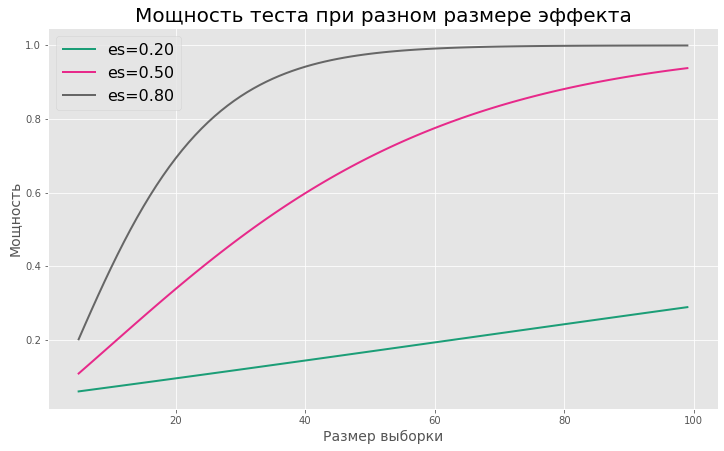

In [ ]:
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))

analysis = TTestIndPower()

_, axes = plt.subplots(1, 1, figsize=(12,7))

analysis.plot_power(
    dep_var='nobs',
    nobs=sample_sizes,
    effect_size=effect_sizes,
    ax=axes
)

axes.set_title("Мощность теста при разном размере эффекта", fontsize=20)
axes.set_xlabel("Размер выборки", fontsize=14)
axes.set_ylabel("Мощность", fontsize=14)
plt.legend(fontsize=16);


На графике мы видим как меняется мощность критерия при трёх разных размерах эффекта. Если нас интересует большой эффект, то мы выходим к единице при примерно $60$ наблюдениях.

---
---

## 3. Множественная проверка гипотез



Говорят, Джордж Р.Р. Мартин, автор цикла "Песнь Льда и Пламени", истребляет Старков: чаще убивает персонажей, относящихся к этому дому, чем персонажей других домов. В таблице ниже приведено количество персонажей, относящихся к тому или иному дому, упомянутых за первые $4$ книги, а так же количество погибших персонажей.

| Дом | Упомянутые персонажи | Погибшие персонажи|
|---|---|---|
|House Stark | 70 | 25 |
|House Lannister | 38 | 7 |
|House Greyjoy | 41 | 12 |
|Night's Watch | 105 | 41 |

Нужно проверить гипотезу об этом на $5\%$ уровне значимости.

__Формализация задачи:__
Нам нужно проверить гипотезу о том, что доля смертей среди Старков совпадает со всеми остальными долями против альтернативы, что хотя бы в одной из ситуаций смертность в доме Старков больше:

$$\begin{equation*}
\begin{aligned}
& H_0: p_S = p_L = p_G = p_{NW}  \\
&H_1: \text{хотя бы одна вероятность отличается}
\end{aligned}
\end{equation*}$$

Протестируем все гипотезы без коррекции на множественное тестирование, а потом введём её.

In [ ]:
n_st = 70
m_st = 25

n_lan = 38
m_lan = 7

n_gr = 41
m_gr = 12

n_nw = 105
m_nw = 41

alpha = 0.05

In [ ]:
m_st/n_st, m_lan/n_lan, m_gr/n_gr, m_nw/n_nw

(0.35714285714285715,
 0.18421052631578946,
 0.2926829268292683,
 0.3904761904761905)

Проверяем три гипотезы!

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

_, p1 =  proportions_ztest((m_st, m_lan),
                           (n_st, n_lan),
                           value=0,
                           alternative='larger')


_, p2 =  proportions_ztest((m_st, m_gr),
                           (n_st, n_gr),
                           value=0,
                           alternative='larger')

_, p3 =  proportions_ztest((m_st, m_nw),
                           (n_st, n_nw),
                           value=0,
                           alternative='larger')

pval = np.array([p1, p2, p3])
pval

array([0.03008672, 0.24343199, 0.67209806])

In [ ]:
pval > 0.05 # без коррекции, TRUE - не отвергается

array([False,  True,  True])

Самая первая гипотеза отвергается. Отсюда делаем вывод, что смертность значимо различается. Помним, что ошибка первого рода - ошибочный выбор альтернативы. В случае, когда мы никак не контролируем уровень значимости она оказывается завышена. Посмотрим, что будет происходить при корекции.

__а) Коррекция Бонферрони__

In [ ]:
pval > 0.05/3  # поделили уровень значимости на число гипотез

array([ True,  True,  True])

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

rejected, p_corrected, _, _ = multipletests(pval,
                                            alpha = 0.05,
                                            method = 'bonferroni')
p_corrected

array([0.09026015, 0.73029598, 1.        ])

In [ ]:
p_corrected > 0.05 # TRUE - не отвергается

array([ True,  True,  True])

Все три гипотезы о равенстве смертностей не отвергаются.

__б) Метод Холма__

In [ ]:
rejected, p_corrected, _, _ = multipletests(pval,
                                            alpha = 0.05,
                                            method = 'holm')
p_corrected

array([0.09026015, 0.48686399, 0.67209806])

In [ ]:
p_corrected > 0.05 # TRUE - не отвергается

array([ True,  True,  True])

Все три гипотезы о равенстве смертностей не отвергаются.

__в) Метод Бенджамини-Хохберга__

In [ ]:
rejected, p_corrected, _, _ = multipletests(pval,
                                            alpha = 0.05,
                                            method = 'fdr_bh')
p_corrected

array([0.09026015, 0.36514799, 0.67209806])

In [ ]:
p_corrected > 0.05 # TRUE - не отвергается

array([ True,  True,  True])

Все три гипотезы о равенстве смертностей не отвергаются.

---
---

## 4. Примеры

А/B тестирование и анализ данных в Python // Урок 6 от Skypro
https://www.youtube.com/watch?v=cjMhezRVDq0


Анализ статистики во free-to-play играх: инструменты аналитика
https://habr.com/ru/company/alawar/blog/162739/


Как быстро и дешево сделать сегментирование пользователей и A/B-тестирование для приложения iOS
https://habr.com/ru/post/182804/

«Добавить в корзину» против «Купить в один клик»: результаты АБ-теста
https://habr.com/ru/company/webasyst/blog/207872/

A/B testing: время — ничто, анимация — все!
https://habr.com/ru/post/212637/

Ошибки A/B-тестирования в AirBnB
https://habr.com/ru/company/cloverr/blog/224461/

A/B-тестирование и его результаты, которые шокировали экспертов: интуиция иногда подводит
https://habr.com/ru/post/229507/
